In [1]:
import sys
import os
import re
import time
from tqdm import tqdm


# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"
os.environ["HF_HOME"] = "~/scratch/hf-cache"
token=""
print(os.environ['WANDB_DISABLED'])  # Should output "true"
print(os.environ['HF_HOME'])  # Should output "~/scratch/hf-cache"

#output_file = open('mt5_test', 'w')
#sys.stdout = output_file
#sys.stderr = output_file

true
~/scratch/hf-cache


In [3]:
from datasets import load_dataset
#from google.colab import drive
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
from datasets import load_dataset, DatasetDict

sns.set()

In [4]:
def filter_sentences(example):
    # Check sentence length
    if not (3 < len(example['translation']['en'].split()) < 30):
        return False
    if not (3 < len(example['translation']['hi'].split()) < 30):
        return False
    
    # Check for non-ASCII non-Unicode characters in Hindi text
    if re.search(r'[^\u0000-\u007F\u0900-\u097F]', example['translation']['hi']):
        return False
    
    # Hook for further restrictions (can be customized)
    # Example: if 'specific_word' in example['translation']['en']:
    #     return False
    
    return True

In [5]:
def get_reduced_dataset(dataset_name, train_size=14000, val_size=2000, test_size=4000):
    orig_data_set = load_dataset(dataset_name)
    print(orig_data_set)
    # Filter the dataset based on the criteria
    filtered_dataset = orig_data_set['train'].filter(filter_sentences)
    print(filtered_dataset)
    
    # Split the filtered dataset into train, validation, and test sets
    train_val_test_split = filtered_dataset.train_test_split(test_size=val_size + test_size, seed=42)
    val_test_split = train_val_test_split['test'].train_test_split(test_size=test_size, seed=42)
    
    small_data_set = DatasetDict({
        'train': train_val_test_split['train'].select(range(train_size)),
        'validation': val_test_split['train'],
        'test': val_test_split['test']
    })

    # Verify the size of the new dataset
    print(small_data_set)
    print(f"New train set size: {len(small_data_set['train'])}")
    print(f"New validation set size: {len(small_data_set['validation'])}")
    print(f"New test set size: {len(small_data_set['test'])}")
    
    return small_data_set

In [6]:
dataset_name = "cfilt/iitb-english-hindi"
#small_data_set = get_reduced_dataset(dataset_name)
small_data_set = get_reduced_dataset(dataset_name, train_size = 28000, val_size=4000, test_size=8000)
# Initialize a global variable to keep track of the last print time
last_print_time = time.time()

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})
Dataset({
    features: ['translation'],
    num_rows: 839876
})
DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 28000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8000
    })
})
New train set size: 28000
New validation set size: 4000
New test set size: 8000


In [7]:
model_repo = 'google/mt5-base'
model_path = './mt5_test_some'
tokenizer = AutoTokenizer.from_pretrained(model_repo, force_fownload=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo, force_download=True)
model = model.cuda()

# Save the model and tokenizer to the specified path
tokenizer.save_pretrained(model_path)
model.save_pretrained(model_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/storage/ice1/1/2/spadmanabha3/satkp/BigData/LLM/conda/LLM_test/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  war

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [8]:
token_ids = tokenizer.encode(
    ' This will be translated to Japanese! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1494,    898,    390,  37194,    285,    288,  30865,    309,    274,
         116024,  11994,    271,      1]], device='cuda:0')


/storage/ice1/1/2/spadmanabha3/satkp/BigData/LLM/conda/LLM_test/lib/python3.9/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     0, 250099,    259,    264,    259,  70471,  54854,      1]],
       device='cuda:0')
<pad> <extra_id_0> - Wikimedia Commons</s>


In [9]:
example_input_str = ' This is just a test nbuig.'
# example_input_str = 'これは普通のテスト'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1494,  339, 1627,  259,  262, 2978,  259,  272, 1982, 1315,  260,    1]])
Tokens: ['▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [10]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

In [11]:

LANG_TOKEN_MAPPING = {
    'en': '',
    'hi': ''
}
max_seq_len = 20
small_data_set['train'][0]

{'translation': {'en': 'Your local government can provide you with more details about them.',
  'hi': 'इस सब के बारे में आप की स्थानीय शासन सत्ता, अधिक जानकारी दे सकती है. '}}

In [12]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250100, 768)

In [13]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[1494,  339, 1627,  259,  262, 2978,  259,  272, 1982, 1315,  260,    1,
            0,    0,    0,    0,    0,    0,    0,    0]])
['▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [14]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def process_translation_list(translations_list, lang_token_map, tokenizer, seq_len=128):
    input_ids = []
    output_ids = []

    for translation in translations_list:
        formatted_data = format_translation_data(translation, lang_token_map, tokenizer, seq_len)
        if formatted_data is None:
            continue

        input_token_ids, target_token_ids = formatted_data
        input_ids.append(input_token_ids.tolist())  # Convert tensor to list
        output_ids.append(target_token_ids.tolist())  # Convert tensor to list

    return input_ids, output_ids

def format_translation_data(translation, lang_token_map, tokenizer, seq_len=128):
    # Get the translations for the batch
    input_text = translation.get('en')
    target_text = translation.get('hi')

    if input_text is None or target_text is None:
        return None

    input_token_ids = encode_input_str(
        input_text, 'hi', tokenizer, seq_len, lang_token_map)

    target_token_ids = encode_target_str(
        target_text, tokenizer, seq_len, lang_token_map)

    return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [15]:
print(small_data_set)
print(small_data_set['train']['translation'][0])

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 28000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8000
    })
})
{'en': 'Your local government can provide you with more details about them.', 'hi': 'इस सब के बारे में आप की स्थानीय शासन सत्ता, अधिक जानकारी दे सकती है. '}


In [16]:
# Testing `data_transform`
in_ids, out_ids = process_translation_list(
    small_data_set['train']['translation'], LANG_TOKEN_MAPPING, tokenizer)

# Print the first set of token IDs for input and output
print(' '.join(tokenizer.convert_ids_to_tokens(in_ids[0])))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids[0])))

# Testing data generator
data_gen = get_data_generator(small_data_set['train'], LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

▁Your ▁local ▁government ▁can ▁provide ▁you ▁with ▁more ▁details ▁about ▁them . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁इस ▁सब ▁के ▁ बारे ▁में ▁आप ▁की ▁स्थान ीय ▁ शासन ▁ सत्ता , ▁अधिक ▁जान कारी ▁दे ▁सक ती ▁है . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [17]:
#model.load_state_dict(torch.load(model_path))

In [18]:
# Constants
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(small_data_set['train']) / batch_size))
print(n_batches)
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)
losses = []

1750


/storage/ice1/1/2/spadmanabha3/satkp/BigData/LLM/conda/LLM_test/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:

def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [21]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(small_data_set['train'], LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, small_data_set['validation'])
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      tokenizer.save_pretrained(model_path)
      model.save_pretrained(model_path)

# Save the final model
tokenizer.save_pretrained(model_path)
model.save_pretrained(model_path)

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 1.816 | lr: 0.0004671717171717172
Epoch: 1 | Step: 100 | Avg. loss: 1.813 | lr: 0.00046536796536796537
Epoch: 1 | Step: 150 | Avg. loss: 1.859 | lr: 0.0004635642135642136
Epoch: 1 | Step: 200 | Avg. loss: 1.800 | lr: 0.00046176046176046176
Epoch: 1 | Step: 250 | Avg. loss: 1.891 | lr: 0.00045995670995671
Epoch: 1 | Step: 300 | Avg. loss: 1.766 | lr: 0.00045815295815295815
Epoch: 1 | Step: 350 | Avg. loss: 1.753 | lr: 0.0004563492063492063
Epoch: 1 | Step: 400 | Avg. loss: 1.778 | lr: 0.00045454545454545455
Epoch: 1 | Step: 450 | Avg. loss: 1.757 | lr: 0.0004527417027417027
Epoch: 1 | Step: 500 | Avg. loss: 1.837 | lr: 0.00045093795093795094
Epoch: 1 | Step: 550 | Avg. loss: 1.724 | lr: 0.0004491341991341991
Epoch: 1 | Step: 600 | Avg. loss: 1.739 | lr: 0.0004473304473304474
Epoch: 1 | Step: 650 | Avg. loss: 1.773 | lr: 0.00044552669552669555
Epoch: 1 | Step: 700 | Avg. loss: 1.765 | lr: 0.0004437229437229438
Epoch: 1 | Step: 750 | Avg. loss: 1.733 | lr:

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 1.200 | lr: 0.00040404040404040404
Epoch: 2 | Step: 100 | Avg. loss: 1.177 | lr: 0.0004022366522366522
Epoch: 2 | Step: 150 | Avg. loss: 1.189 | lr: 0.00040043290043290043
Epoch: 2 | Step: 200 | Avg. loss: 1.211 | lr: 0.0003986291486291486
Epoch: 2 | Step: 250 | Avg. loss: 1.297 | lr: 0.0003968253968253968
Epoch: 2 | Step: 300 | Avg. loss: 1.235 | lr: 0.000395021645021645
Epoch: 2 | Step: 350 | Avg. loss: 1.190 | lr: 0.00039321789321789327
Epoch: 2 | Step: 400 | Avg. loss: 1.236 | lr: 0.00039141414141414144
Epoch: 2 | Step: 450 | Avg. loss: 1.201 | lr: 0.00038961038961038966
Epoch: 2 | Step: 500 | Avg. loss: 1.193 | lr: 0.00038780663780663783
Epoch: 2 | Step: 550 | Avg. loss: 1.256 | lr: 0.000386002886002886
Epoch: 2 | Step: 600 | Avg. loss: 1.243 | lr: 0.0003841991341991342
Epoch: 2 | Step: 650 | Avg. loss: 1.253 | lr: 0.0003823953823953824
Epoch: 2 | Step: 700 | Avg. loss: 1.216 | lr: 0.0003805916305916306
Epoch: 2 | Step: 750 | Avg. loss: 1.262 | lr:

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 0.735 | lr: 0.0003409090909090909
Epoch: 3 | Step: 100 | Avg. loss: 0.755 | lr: 0.00033910533910533916
Epoch: 3 | Step: 150 | Avg. loss: 0.715 | lr: 0.00033730158730158733
Epoch: 3 | Step: 200 | Avg. loss: 0.770 | lr: 0.0003354978354978355
Epoch: 3 | Step: 250 | Avg. loss: 0.732 | lr: 0.0003336940836940837
Epoch: 3 | Step: 300 | Avg. loss: 0.802 | lr: 0.0003318903318903319
Epoch: 3 | Step: 350 | Avg. loss: 0.766 | lr: 0.0003300865800865801
Epoch: 3 | Step: 400 | Avg. loss: 0.799 | lr: 0.0003282828282828283
Epoch: 3 | Step: 450 | Avg. loss: 0.838 | lr: 0.0003264790764790765
Epoch: 3 | Step: 500 | Avg. loss: 0.772 | lr: 0.0003246753246753247
Epoch: 3 | Step: 550 | Avg. loss: 0.772 | lr: 0.0003228715728715729
Epoch: 3 | Step: 600 | Avg. loss: 0.813 | lr: 0.00032106782106782107
Epoch: 3 | Step: 650 | Avg. loss: 0.769 | lr: 0.00031926406926406924
Epoch: 3 | Step: 700 | Avg. loss: 0.824 | lr: 0.00031746031746031746
Epoch: 3 | Step: 750 | Avg. loss: 0.816 | lr

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 0.435 | lr: 0.0002777777777777778
Epoch: 4 | Step: 100 | Avg. loss: 0.413 | lr: 0.000275974025974026
Epoch: 4 | Step: 150 | Avg. loss: 0.428 | lr: 0.00027417027417027417
Epoch: 4 | Step: 200 | Avg. loss: 0.434 | lr: 0.0002723665223665224
Epoch: 4 | Step: 250 | Avg. loss: 0.435 | lr: 0.00027056277056277056
Epoch: 4 | Step: 300 | Avg. loss: 0.446 | lr: 0.00026875901875901873
Epoch: 4 | Step: 350 | Avg. loss: 0.469 | lr: 0.00026695526695526696
Epoch: 4 | Step: 400 | Avg. loss: 0.431 | lr: 0.0002651515151515151
Epoch: 4 | Step: 450 | Avg. loss: 0.475 | lr: 0.00026334776334776335
Epoch: 4 | Step: 500 | Avg. loss: 0.477 | lr: 0.0002615440115440115
Epoch: 4 | Step: 550 | Avg. loss: 0.475 | lr: 0.00025974025974025974
Epoch: 4 | Step: 600 | Avg. loss: 0.468 | lr: 0.00025793650793650796
Epoch: 4 | Step: 650 | Avg. loss: 0.476 | lr: 0.0002561327561327562
Epoch: 4 | Step: 700 | Avg. loss: 0.469 | lr: 0.00025432900432900436
Epoch: 4 | Step: 750 | Avg. loss: 0.483 | 

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 0.225 | lr: 0.00021464646464646465
Epoch: 5 | Step: 100 | Avg. loss: 0.220 | lr: 0.00021284271284271284
Epoch: 5 | Step: 150 | Avg. loss: 0.214 | lr: 0.00021103896103896104
Epoch: 5 | Step: 200 | Avg. loss: 0.237 | lr: 0.00020923520923520926
Epoch: 5 | Step: 250 | Avg. loss: 0.246 | lr: 0.00020743145743145743
Epoch: 5 | Step: 300 | Avg. loss: 0.246 | lr: 0.00020562770562770563
Epoch: 5 | Step: 350 | Avg. loss: 0.240 | lr: 0.00020382395382395382
Epoch: 5 | Step: 400 | Avg. loss: 0.240 | lr: 0.00020202020202020202
Epoch: 5 | Step: 450 | Avg. loss: 0.236 | lr: 0.00020021645021645022
Epoch: 5 | Step: 500 | Avg. loss: 0.246 | lr: 0.0001984126984126984
Epoch: 5 | Step: 550 | Avg. loss: 0.233 | lr: 0.00019660894660894664
Epoch: 5 | Step: 600 | Avg. loss: 0.248 | lr: 0.00019480519480519483
Epoch: 5 | Step: 650 | Avg. loss: 0.255 | lr: 0.000193001443001443
Epoch: 5 | Step: 700 | Avg. loss: 0.248 | lr: 0.0001911976911976912
Epoch: 5 | Step: 750 | Avg. loss: 0.246

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 0.111 | lr: 0.00015151515151515152
Epoch: 6 | Step: 100 | Avg. loss: 0.109 | lr: 0.0001497113997113997
Epoch: 6 | Step: 150 | Avg. loss: 0.118 | lr: 0.0001479076479076479
Epoch: 6 | Step: 200 | Avg. loss: 0.102 | lr: 0.0001461038961038961
Epoch: 6 | Step: 250 | Avg. loss: 0.119 | lr: 0.0001443001443001443
Epoch: 6 | Step: 300 | Avg. loss: 0.110 | lr: 0.00014249639249639252
Epoch: 6 | Step: 350 | Avg. loss: 0.108 | lr: 0.0001406926406926407
Epoch: 6 | Step: 400 | Avg. loss: 0.117 | lr: 0.0001388888888888889
Epoch: 6 | Step: 450 | Avg. loss: 0.116 | lr: 0.00013708513708513709
Epoch: 6 | Step: 500 | Avg. loss: 0.111 | lr: 0.00013528138528138528
Epoch: 6 | Step: 550 | Avg. loss: 0.123 | lr: 0.00013347763347763348
Epoch: 6 | Step: 600 | Avg. loss: 0.116 | lr: 0.00013167388167388167
Epoch: 6 | Step: 650 | Avg. loss: 0.116 | lr: 0.00012987012987012987
Epoch: 6 | Step: 700 | Avg. loss: 0.110 | lr: 0.0001280663780663781
Epoch: 6 | Step: 750 | Avg. loss: 0.117 | 

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 0.050 | lr: 8.838383838383838e-05
Epoch: 7 | Step: 100 | Avg. loss: 0.044 | lr: 8.658008658008658e-05
Epoch: 7 | Step: 150 | Avg. loss: 0.044 | lr: 8.477633477633479e-05
Epoch: 7 | Step: 200 | Avg. loss: 0.042 | lr: 8.297258297258297e-05
Epoch: 7 | Step: 250 | Avg. loss: 0.051 | lr: 8.116883116883117e-05
Epoch: 7 | Step: 300 | Avg. loss: 0.043 | lr: 7.936507936507937e-05
Epoch: 7 | Step: 350 | Avg. loss: 0.049 | lr: 7.756132756132757e-05
Epoch: 7 | Step: 400 | Avg. loss: 0.040 | lr: 7.575757575757576e-05
Epoch: 7 | Step: 450 | Avg. loss: 0.046 | lr: 7.395382395382395e-05
Epoch: 7 | Step: 500 | Avg. loss: 0.042 | lr: 7.215007215007215e-05
Epoch: 7 | Step: 550 | Avg. loss: 0.046 | lr: 7.034632034632035e-05
Epoch: 7 | Step: 600 | Avg. loss: 0.045 | lr: 6.854256854256854e-05
Epoch: 7 | Step: 650 | Avg. loss: 0.046 | lr: 6.673881673881674e-05
Epoch: 7 | Step: 700 | Avg. loss: 0.051 | lr: 6.493506493506494e-05
Epoch: 7 | Step: 750 | Avg. loss: 0.048 | lr: 6.3

/tmp/ipykernel_340996/1579356082.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1750 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 0.017 | lr: 2.5252525252525253e-05
Epoch: 8 | Step: 100 | Avg. loss: 0.011 | lr: 2.344877344877345e-05
Epoch: 8 | Step: 150 | Avg. loss: 0.017 | lr: 2.1645021645021645e-05
Epoch: 8 | Step: 200 | Avg. loss: 0.014 | lr: 1.984126984126984e-05
Epoch: 8 | Step: 250 | Avg. loss: 0.012 | lr: 1.8037518037518038e-05
Epoch: 8 | Step: 300 | Avg. loss: 0.014 | lr: 1.6233766233766234e-05
Epoch: 8 | Step: 350 | Avg. loss: 0.014 | lr: 1.443001443001443e-05
Epoch: 8 | Step: 400 | Avg. loss: 0.009 | lr: 1.2626262626262626e-05
Epoch: 8 | Step: 450 | Avg. loss: 0.016 | lr: 1.0822510822510823e-05
Epoch: 8 | Step: 500 | Avg. loss: 0.010 | lr: 9.018759018759019e-06
Epoch: 8 | Step: 550 | Avg. loss: 0.011 | lr: 7.215007215007215e-06
Epoch: 8 | Step: 600 | Avg. loss: 0.013 | lr: 5.411255411255411e-06
Epoch: 8 | Step: 650 | Avg. loss: 0.012 | lr: 3.6075036075036075e-06
Epoch: 8 | Step: 700 | Avg. loss: 0.012 | lr: 1.8037518037518038e-06
Epoch: 8 | Step: 750 | Avg. loss: 0.012 |

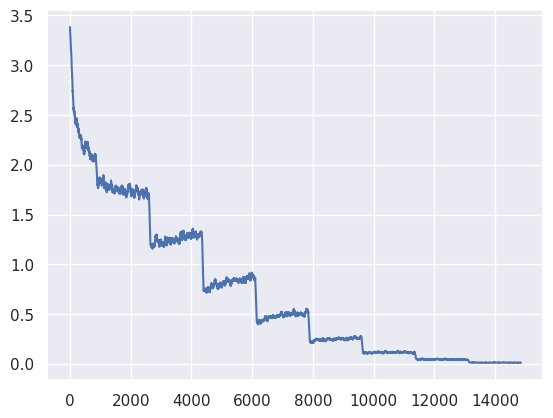

In [22]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [25]:
test_sentence = small_data_set['train']['translation'][0]['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'hi',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Your local government can provide you with more details about them.
Truncated input text: Your local government can provide you with more details about them.</s><pad><pad><pad><pad><pad><pad><pad>


In [27]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

उन सब के बारे में आप की स्थानीय शासन सत्ता, अधिक जानकारी दे
